### Load libraries and data

In [1]:
import sys
from datetime import date, timedelta
from itertools import product

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

sys.path.insert(0, "src")
from mfs_utilities import flight_plot, kayak_scraper

In [2]:
all_airports = pd.read_pickle("data/airportdf.pkl")

In [3]:
# Create dataframe with only medium and large hubs
to_keep_row = all_airports["Hub"].isin(["M", "L"])
to_keep_col = to_keep_row.tolist() + [True] * (
    all_airports.shape[1] - all_airports.shape[0]
)
airport_hubs = all_airports.loc[to_keep_row, to_keep_col]

### Specify trip settings

In [4]:
# Airports originating from
origins = [
    "ORD",
    "RDU",
    "BOS",
    "ATL",
]

# Departure date
startdate = date.today() + timedelta(days=150)

# Stay duration
days = 5

### Find closest airports

In [5]:
nClosest = 3
totalDistance = np.sum(
    [airport_hubs.loc[x, airport_hubs.index] for x in origins], axis=0
)
sortidx = np.argsort(totalDistance)
closest = airport_hubs.index[sortidx][:nClosest]
closestdf = airport_hubs.loc[closest]
closestdf["total_distance"] = totalDistance[sortidx[:nClosest]]
closest.to_list()

['RDU', 'CLT', 'CMH']

### Define flights to be scraped

In [6]:
flights = []
for d in closestdf.index:
    for o in origins:
        if o != d:
            flights.append((o, d))
flights

[('ORD', 'RDU'),
 ('BOS', 'RDU'),
 ('ATL', 'RDU'),
 ('ORD', 'CLT'),
 ('RDU', 'CLT'),
 ('BOS', 'CLT'),
 ('ATL', 'CLT'),
 ('ORD', 'CMH'),
 ('RDU', 'CMH'),
 ('BOS', 'CMH'),
 ('ATL', 'CMH')]

### Scrape kayak for flight data

In [7]:
results = kayak_scraper(flights, startdate, days, all_airports, timeout=60)
results.drop_duplicates(
    subset=["origin", "destination", "price", "legs_1", "legs_2"], inplace=True
)

Getting 1/11 5 sec
Getting 2/11 3 sec
Getting 3/11 3 sec
Getting 4/11 3 sec
Getting 5/11 3 sec
Getting 6/11 2 sec
Getting 7/11 3 sec
Getting 8/11 2 sec
Getting 9/11 3 sec
Getting 10/11 2 sec
Getting 11/11 3 sec


### Examine dataframe produced

In [8]:
results.head()

,depart_time_1,arrive_time_1,depart_time_2,arrive_time_2,price,stops_1,stops_2,origin,destination,legs_1,legs_2,distance_mi
0,2022-05-10 08:20:00-05:00,2022-05-10 11:05:00-04:00,2022-05-10 06:25:00-05:00,2022-05-10 07:45:00-04:00,197,nonstop,nonstop,ORD,RDU,"((ORD, RDU),)","((RDU, ORD),)",1292.396107
6,2022-05-10 11:45:00-05:00,2022-05-10 14:30:00-04:00,2022-05-10 05:44:00-05:00,2022-05-10 08:37:00-04:00,205,nonstop,[CLT],ORD,RDU,"((ORD, RDU),)","((RDU, CLT), (CLT, ORD))",1375.301092
8,2022-05-10 11:17:00-05:00,2022-05-10 15:38:00-04:00,2022-05-10 06:25:00-05:00,2022-05-10 07:45:00-04:00,205,[CLT],nonstop,ORD,RDU,"((ORD, CLT), (CLT, RDU))","((RDU, ORD),)",1375.301092
0,2022-05-10 11:53:00-04:00,2022-05-10 15:38:00-04:00,2022-05-10 05:48:00-04:00,2022-05-10 10:56:00-04:00,213,[CLT],[DCA],BOS,RDU,"((BOS, CLT), (CLT, RDU))","((RDU, DCA), (DCA, BOS))",1483.246943
7,2022-05-10 06:00:00-04:00,2022-05-10 09:39:00-04:00,2022-05-10 08:18:00-04:00,2022-05-10 13:07:00-04:00,215,[IAD],[JFK],BOS,RDU,"((BOS, IAD), (IAD, RDU))","((RDU, JFK), (JFK, BOS))",1249.925850


### Compute prices and distances of all flight purchase combinations

In [9]:
all_prices = []
all_dists = []
g_by_dest = results.groupby("destination")
for d in closestdf.index:
    this_dest_df = g_by_dest.get_group(d)
    g_by_origin = this_dest_df.groupby("origin")
    choices = list(product(*g_by_origin.indices.values()))
    choices_dfs = list(map(lambda x: this_dest_df.iloc[[*x]], choices))
    prices = list(map(lambda x: x.price.sum(), choices_dfs))
    dists = list(map(lambda x: x.distance_mi.sum(), choices_dfs))
    all_prices.extend(prices)
    all_dists.extend(dists)

### Total distance vs price for all combinations

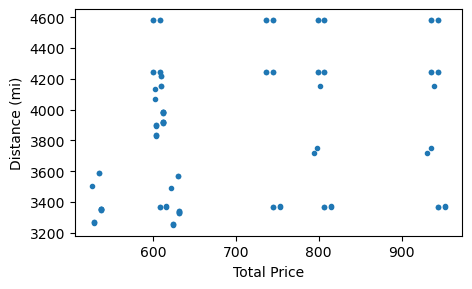

In [10]:
plt.figure(figsize=(5, 3), dpi=100)
plt.plot(all_prices, all_dists, ".")
plt.ylabel("Distance (mi)")
plt.xlabel("Total Price");

### Map flight paths, colored by distance

In [11]:
m = flight_plot(results, all_airports, 4)
m